In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astroML import stats
import urllib.request
import os
import math

# for downloading 
def download(PATH,local_name,format_offile):
    '''This function takes PATH which is url of file and local_name i.e the name of file after downloaded and format
    file and downloads the file from web and stores in your path'''
    local_path=os.path.join("./",f'{local_name}.{format_offile}')
    urllib.request.urlretrieve(PATH,local_path)

<p>Q1. Download the data corresponding to x, y, and $\sigma_y$ from $\href{https://people.iith.ac.in/shantanud/testdata.dat}{link}$. Find the best-fit values after fitting the data to linear, quadratic, and cubic polynomials. Find out which model fits the data best from frequentist model comparison as well as using AIC and BIC. For frequentist model comparison, using the linear model as the null hypothesis, find out the p value corresponding to the preferred model. (or if the linear model is the prefered model, then compare it to the quadratic model). Also show a plot overlaying the data with best fit solutions from linear, quadratic and cubic functions with different line styles for each of the fits.</p>

In [2]:
download("https://people.iith.ac.in/shantanud/testdata.dat","data","dat")
# to download the file

In [3]:
datContent = [i.strip().split() for i in open("data.dat").readlines()] #Reading .dat file in python
datContent.pop(0)
dt=np.array(datContent)
dt=dt.astype(float)
# storing downloaded data in numpy nd array
x,y,sigmay=dt[:,0],dt[:,1],dt[:,2]
data=np.array([x,y,sigmay])
# storing nd array in individual axes

### METHOD - 1 : USING CURVE_FIT FUNCTION

In [4]:
# Best fit parameters of each of the three different models using curve_fit function
def linear_function(x,m,b):
    return m*x+b

def quadratic_function(x,m,b,c):
    return m*x*x+b*x+c

def cubic_function(x,m,b,c,d):
    return m*x*x*x+b*x*x+c*x+d

def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

param_linear = scipy.optimize.curve_fit(linear_function, xdata=x, ydata=y,sigma=sigmay)
param_quadratic = scipy.optimize.curve_fit(quadratic_function, xdata=x, ydata=y,sigma=sigmay)
param_cubic = scipy.optimize.curve_fit(cubic_function, xdata=x, ydata=y,sigma=sigmay)

print("Best fit parameters for linear model after Chisquare minimization is",param_linear[0])
print("Best fit parameters for quadratic model after Chisquare minimization is",param_quadratic[0])
print("Best fit parameters for cubic model after Chisquare minimization is",param_cubic[0])

Best fit parameters for linear model after Chisquare minimization is [ 2.79789861 -1.11028082]
Best fit parameters for quadratic model after Chisquare minimization is [ 0.50261299  2.38475183 -1.05578915]
Best fit parameters for cubic model after Chisquare minimization is [-0.96724913  1.74451231  1.97184089 -1.02910465]


### METHOD - 2 : USING GAUSSIAN LIKELIHOOD OR CHISQUARE MINIMIZATION

In [5]:
def logL(theta, pdata):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = pdata
    y_fit = polynomial_fit(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

In [6]:
def best_theta(degree,pdata):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, pdata)
    return scipy.optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta1 = best_theta(1,data)
theta2 = best_theta(2,data)
theta3 = best_theta(3,data)

# Used in JVDP blog 

print("Best fit parameters for linear model after Chisquare minimization is",theta1)
print("Best fit parameters for quadratic model after Chisquare minimization is",theta2)
print("Best fit parameters for cubic model after Chisquare minimization is",theta3)

Best fit parameters for linear model after Chisquare minimization is [-1.11028083  2.79789863]
Best fit parameters for quadratic model after Chisquare minimization is [-1.05578918  2.38475198  0.50261283]
Best fit parameters for cubic model after Chisquare minimization is [-1.02910477  1.97184151  1.74451214 -0.96724975]


<p>You can see that we have same results (varying after 6th decimal point although). The notation followed in method-2 is reverse of method -1 so we got the array of theta values reversed.</p>

In [7]:
# computing the maximum likelihood of each model and comparing
def compute_chi2(degree, data=data):
    x, y, sigmay = data
    theta = best_theta(degree, data)
    z = (y - polynomial_fit(theta, x)) / sigmay
    return np.sum(z*z)

def compute_dof(degree, data=data):
    return data.shape[1] - (degree + 1)

def chi2_likelihood(degree, data=data):
    chi2 = compute_chi2(degree, data)
    dof = compute_dof(degree, data)
    return scipy.stats.chi2(dof).pdf(chi2)

print("chi2 likelihood - linear model:    ", chi2_likelihood(1))
print("chi2 likelihood - quadratic model: ", chi2_likelihood(2))
print("chi2 likelihood - cubic model: ", chi2_likelihood(3))

chi2 likelihood - linear model:     0.04538379558592021
chi2 likelihood - quadratic model:  0.03660844755014303
chi2 likelihood - cubic model:  0.04215280601015009


In [23]:
np.log(logL(best_theta(1,data),data))

3.0918758972218456

<p>From the above using Frequentist model selection as we want higher $\chi^2$ likelihood value for comparitively good model, we conclude that linear model is more suitable for fitting of the given data.</p>

In [25]:
# calculating AIC=2*K-2*logL(model) for each of the model and for model to be selected it should have minimum AIC
AIC_linear = 4-2*logL(best_theta(1,data),data)
AIC_quadratic = 6-2*logL(best_theta(2,data),data)
AIC_cubic = 8-2*logL(best_theta(3,data),data)

print(f"AIC of linear model is {AIC_linear}, for quadratic model is {AIC_quadratic} and cubic model is {AIC_cubic}")

AIC of linear model is -40.036686816072525, for quadratic model is -39.84982062400534 and cubic model is -38.26081851759466


<p>From the above, we can clearly see that AIC is the lowest for linear model so it fits better according to Akaike information criterion(AIC)</p>

In [9]:
# calculating BIC=KlnN-2*logL(model) for each of the model and for model to be selected it should have minimum BIC
N=len(x) #number of data points
BIC_linear = 2*math.log(N)-2*logL(best_theta(1,data),data)
BIC_quadratic = 3*math.log(N)-2*logL(best_theta(2,data),data)
BIC_cubic = 4*math.log(N)-2*logL(best_theta(3,data),data)

print(f"BIC of linear model is {BIC_linear}, for quadratic model is {BIC_quadratic} and cubic model is {BIC_cubic}")

BIC of linear model is -38.045222268964544, for quadratic model is -36.86262380334337 and cubic model is -34.277889423378696


<p>Even for BIC from the above, we can clearly see that BIC is the lowest for linear model so it fits better according to Bayesian information criterion(BIC)</p>

In [10]:
# As linear model is preferred so the below is null hypothesis testing for quadratic wrt linear model
y_pred_linear = linear_function(x,theta1[0],theta1[1])
chisq_linear = compute_chi2(1,data)
y_pred_quadratic = quadratic_function(x,theta2[0],theta2[1],theta2[2])
chisq_quadratic = compute_chi2(2,data)
p_value=scipy.stats.chi2(1).sf(abs(chisq_quadratic-chisq_linear))

print("p value from null hypothesis testing quadratic over linear (as linear is preferred model) is",p_value)

p value from null hypothesis testing quadratic over linear (as linear is preferred model) is 0.17813275695317554


<p>From the above, we have obtained that p value is greater than 0.05 which means that our null hypothesis is true.</p>

Text(0, 0.5, 'y for different models and expected y')

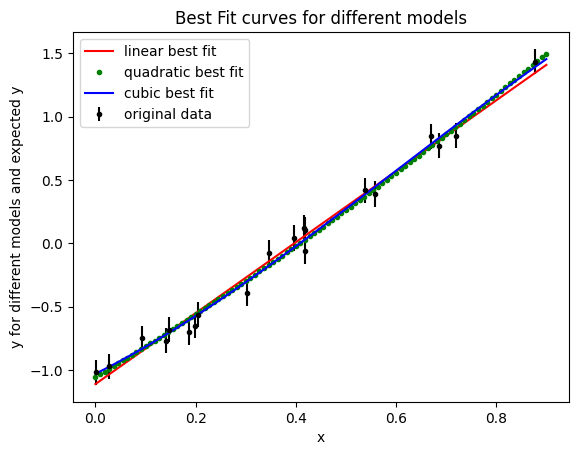

In [11]:
# plotting best fit outputs for different models (using method-1 as it is more appropriate)
p=np.linspace(0,0.9,100)
linear_y=param_linear[0][1]+param_linear[0][0]*p
quadratic_y=param_quadratic[0][2]+param_quadratic[0][1]*p+param_quadratic[0][0]*p*p
cubic_y=param_cubic[0][3]+param_cubic[0][2]*p+param_cubic[0][1]*p*p+param_cubic[0][0]*p*p*p
# y values using each of the three different models

plt.errorbar(x, y, sigmay, label='original data',fmt='.k')
plt.plot(p,linear_y,color='red',label='linear best fit')
plt.plot(p,quadratic_y,'g.',label='quadratic best fit')
plt.plot(p,cubic_y,'b-',label='cubic best fit')
plt.legend()
plt.title('Best Fit curves for different models')
plt.xlabel('x')
plt.ylabel('y for different models and expected y')

<p>Even from the above plot we can clearly see that red is hitting more number of black error bars which eventually confirms it is a better model among linear, quadratic, cubic, even though, they both are almost the same in the given range of x.</p>

<p>Q2. For the model comparison problem shown in class on JVDP’s blog, calculate AIC and BIC for the linear and quadratic models. Do these results agree with the frequentist model comparison results shown on the blog? Also mention the qualitative significance using strength of evidence rules.</p>

In [12]:
jkdata = np.array([[ 0.42,  0.72,0,0.3 ,0.15,0.09,0.19,0.35,0.4 ,0.54,0.42,0.69,0.2,0.88,0.03,0.67,0.42,0.56,0.14,0.2],
            [0.33,0.41,-0.22,0.01, -0.05,-0.05,-0.12,0.26,0.29,0.39,0.31,0.42,-0.01,0.58,-0.2,0.52,0.15,0.32,-0.13,-0.09],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
jkx, jky, jksigmay = jkdata
# data obtained from JVDP blog

In [13]:
# calculating AIC=2*K-2*logL(model) for each of the model and for model to be selected it should have minimum AIC
jkAIC_linear = 4-2*logL(best_theta(1,jkdata),jkdata)
jkAIC_quadratic = 6-2*logL(best_theta(2,jkdata),jkdata)

print(f"For JVDP, AIC of linear model is {jkAIC_linear}, for quadratic model is {jkAIC_quadratic}")

For JVDP, AIC of linear model is -40.0217340132251, for quadratic model is -39.883027173007996


<p>By comparing both the models said in that blog on that data we have AIC of linear model to be least compared to both. So I would prefer linear model with respect to AIC. This result agrees with frequentist model approach given in the blog.</p>

In [14]:
# calculating BIC=KlnN-2*logL(model) for each of the model and for model to be selected it should have minimum BIC
jkN=len(jkx) #number of data points
jkBIC_linear = 2*math.log(N)-logL(best_theta(1,jkdata),jkdata)
jkBIC_quadratic = 3*math.log(N)-logL(best_theta(2,jkdata),jkdata)

print(f"BIC of linear model is {jkBIC_linear}, for quadratic model is {jkBIC_quadratic}")

BIC of linear model is -16.01940245950457, for quadratic model is -13.954316765842025


<p>By comparing both the models said in that blog on that data we have BIC of linear model to be least compared to both. So I would prefer linear model with respect to BIC also. This result agrees with frequentist model approach given in the blog. In short, both BIC and AIC results agrees with the frequentist model selection here. Considering linear model as base model the below are qualitative significance of quadratic over linear model (strength of evidence)</p>

In [15]:
AIC_min=jkAIC_linear
delta_AIC=jkAIC_quadratic-AIC_min #for quadratic model
if(delta_AIC>=0 and delta_AIC<=2):
    print("With respect to AIC, Level of Emperical support of quadratic model is Substanstial ,as, delta AIC is",delta_AIC)
elif(delta_AIC>2 and delta_AIC<=7):
    print("With respect to AIC, Level of Emperical support of quadratic model is considerably less,as,delta AIC",delta_AIC)
else:
    print("With respect to AIC, Level of Emperical support of quadratic model is none ,as, delta AIC is",delta_AIC)

With respect to AIC, Level of Emperical support of quadratic model is Substanstial ,as, delta AIC is 0.1387068402171039


In [16]:
BIC_min=jkBIC_linear
delta_BIC=jkBIC_quadratic-BIC_min #for quadratic model
if(delta_BIC>=0 and delta_BIC<=2):
    print("With respect to BIC, Level of Emperical support of quadratic model is Substanstial ,as, delta BIC is",delta_BIC)
elif(delta_BIC>2 and delta_BIC<=7):
    print("With respect to BIC,Level of Emperical support quadratic model is considerably less ,as, delta BIC is",delta_BIC)
else:
    print("With respect to BIC, Level of Emperical support of quadratic model is none ,as, delta BIC is",delta_BIC)

With respect to BIC,Level of Emperical support quadratic model is considerably less ,as, delta BIC is 2.065085693662544


<p>Q3. Find out one paper in research literature which uses the Kolmogorov-Smirnov test and explain briefly how it was used in that paper. Is K-S test used incorrectly (in this paper) as per the warnings on the Penn State website discussed in class?</p>

<p>For this problem I have considered research paper $\href{https://arxiv.org/pdf/2301.11544.pdf}{\text{Targeted Attacks on Time Forecasting}}$ </a></p>

<p>Time Series Forecasting tasks are heavily seen in real world scenerios like anamoly detection, stock price prediction etc. All these rely in deep learning models which are prone to many vulnerabilities. Authors have demostrated one of the attack in which they have successfully deterioated the accuracy of the model and the KS test is used by the authors to demostrate this effect. (Section 6.3 : KS Test Results and  3.3 : KS Tests in Timeseries)</p>

<p>The author's attack method changed a subset of the training data which is used to build time series forecasting model to make inaccurate predictions for a specific target time series. To evaluate whether they have success after their attack, the authors used the KS test to compare the distribution of errors between the original time series forecasting model and the model that had been attacked. For that they tried on Google stock dataset and Household electric power consumption dataset</p>

<p>Specifically, they used it to compare the CDF of the errors in the original model and the attacked model. They tabulated the KS test results for Original-Targeted, Original-Untargeted, and Targeted-Untargeted attacks as measures of the difference between the distributions. Then they have hypothesised that they are successful on attacking both the datasets Google stock and Household power (page - 8 :Table 1).</p>

<p>I don't see authors using this test out of the context. They done it keeping limitations from that website in the mind. They have just used this as a measure to differentiate the expected model results and inaccurate model results obtained after attacking.</p>

<p>Q4. Answer the following questions.</p>

<li>Calculate the significance in terms of no of sigmas of the Higgs boson discovery claim from the p value given in the abstract of the ATLAS discovery paper, arXiv:1207.7214.</li>

<p>According to abstract of the given paper we have, background fluctuation probability of 1.7×$10^{−9}$ which is our corresponding p value</p>

In [17]:
pvalue_higgs=1.7*pow(10,-9)
# isf computes inverse cdf of the the given p value which is by defination significance
significance_higgs=scipy.stats.norm.isf(pvalue_higgs)
print(f"The significance in terms of no of sigmas of LIGO discovery with p value of {pvalue_higgs} is {significance_higgs}")

The significance in terms of no of sigmas of LIGO discovery with p value of 1.7000000000000001e-09 is 5.911017938341624


<li>Do the same for the LIGO discovery of GW150914, for which the p value = 2 × $10^{−7}$.</li>

In [18]:
pvalue_ligo=2*(pow(10,-7))
# isf computes inverse cdf of the the given p value which is by defination significance
significance_ligo=scipy.stats.norm.isf(pvalue_ligo)
print(f"The significance in terms of no of sigmas of LIGO discovery with p value of {pvalue_ligo} is {significance_ligo}")

The significance in terms of no of sigmas of LIGO discovery with p value of 2e-07 is 5.068957749717791


<li>From the Super-K discovery paper for neutrino oscillations (hep-ex/9807003), calculate the $\chi^2$ GOF using the best-fit $ν_\mu$ ↔ $v_\tau$ oscillation solution.</li>

<p>From the hint, we have The best-fit to $ν_\mu$ $↔$ $v_\tau$ oscillations, $\chi^2_{min}$ = 65.2/67 DOF in the 4th page second column last paragraph. To obtain $\chi^2$ GOF we have to just multiply the 65.2/67 with Degrees of Freedom(DOF) = length of dataset - number of free parameters</p>

In [19]:
DOF=67 #Degrees of freedom
reduced_chisquare=65.2/67 #reduced chisquare of chisquare/DOF
print("The chisquare GOF using the best fit oscillation solution is",reduced_chisquare*DOF)

The chisquare GOF using the best fit oscillation solution is 65.2
